<a href="https://www.kaggle.com/maulberto3/tps-jan2022-simple-histgradboosting-forecasts?scriptVersionId=89513892" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%reset -sf

In [2]:
# Upgrade scikit
#!pip uninstall scikit-learn -y
!pip install -U scikit-learn

     |████████████████████████████████| 24.8 MB 885 kB/s            
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.0 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.2 which is incompatible.


In [3]:
# Patch Xeon Intel OneAPI Scikit accelerator
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

     |████████████████████████████████| 69 kB 888 kB/s            
     |████████████████████████████████| 22.5 MB 1.7 MB/s            
     |████████████████████████████████| 284.3 MB 1.8 kB/s              
     |████████████████████████████████| 4.0 MB 56.4 MB/s            


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.ensemble import HistGradientBoostingRegressor

import matplotlib.pyplot as plt

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [6]:
path = Path().cwd().parent / 'input'
files = list(path.rglob('*'))
files

[PosixPath('/kaggle/input/tabular-playground-series-jan-2022'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/train.csv'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/test.csv')]

In [7]:
train = pd.read_csv(files[2])
train['date'] = pd.to_datetime(train['date'], errors='coerce')
#train = train.set_index('date')

test = pd.read_csv(files[3])
test['date'] = pd.to_datetime(test['date'], errors='coerce')
#test = test.set_index('date')

train
test

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...,...
26293,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441


,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat
...,...,...,...,...,...
6565,32863,2019-12-31,Sweden,KaggleMart,Kaggle Hat
6566,32864,2019-12-31,Sweden,KaggleMart,Kaggle Sticker
6567,32865,2019-12-31,Sweden,KaggleRama,Kaggle Mug
6568,32866,2019-12-31,Sweden,KaggleRama,Kaggle Hat


In [8]:
def pre_process(df):
    df = df.copy()
    #
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['date'] = pd.to_datetime(df['date'])
    df['week']= df['date'].dt.week
    df['day'] = df['date'].dt.day
    df['dayofyear'] = df['date'].dt.dayofyear
    df['daysinmonth'] = df['date'].dt.days_in_month
    df['dayofweek'] = df['date'].dt.dayofweek
    df.loc[(df.date.dt.is_leap_year) & (df.dayofyear >= 60),'dayofyear'] -= 1
    df['weekend'] = (df['date'].dt.weekday >=5).astype(int)
    df['weekday'] = df['date'].dt.weekday
    #
    df['country'] = pd.Categorical(df['country']).codes
    df['store'] = pd.Categorical(df['store']).codes
    df['product'] = pd.Categorical(df['product']).codes
    #
    df = df.drop(columns=['date', 'row_id'])
    return df

train_ = pre_process(train)
test_ = pre_process(test)

train_
test_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,country,store,product,num_sold,year,quarter,month,week,day,dayofyear,daysinmonth,dayofweek,weekend,weekday
0,0,0,1,329,2015,1,1,1,1,1,31,3,0,3
1,0,0,0,520,2015,1,1,1,1,1,31,3,0,3
2,0,0,2,146,2015,1,1,1,1,1,31,3,0,3
3,0,1,1,572,2015,1,1,1,1,1,31,3,0,3
4,0,1,0,911,2015,1,1,1,1,1,31,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,2,0,0,823,2018,4,12,1,31,365,31,0,0,0
26294,2,0,2,250,2018,4,12,1,31,365,31,0,0,0
26295,2,1,1,1004,2018,4,12,1,31,365,31,0,0,0
26296,2,1,0,1441,2018,4,12,1,31,365,31,0,0,0


,country,store,product,year,quarter,month,week,day,dayofyear,daysinmonth,dayofweek,weekend,weekday
0,0,0,1,2019,1,1,1,1,1,31,1,0,1
1,0,0,0,2019,1,1,1,1,1,31,1,0,1
2,0,0,2,2019,1,1,1,1,1,31,1,0,1
3,0,1,1,2019,1,1,1,1,1,31,1,0,1
4,0,1,0,2019,1,1,1,1,1,31,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,2,0,0,2019,4,12,1,31,365,31,1,0,1
6566,2,0,2,2019,4,12,1,31,365,31,1,0,1
6567,2,1,1,2019,4,12,1,31,365,31,1,0,1
6568,2,1,0,2019,4,12,1,31,365,31,1,0,1


In [9]:
# Helpers

def lag_data(data, num_lags):
    """Create lagged features"""
    data = data.copy()
    lags = []
    for i in range(num_lags):
        lagged = data.shift(i+1).fillna(method='bfill')
        lags.append(lagged)
    data = pd.concat([data, *lags], axis=1)
    return data

def smape(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [10]:
# Estimator and params
ts_params = {'loss': 'squared_error',
              'learning_rate': 0.2900707070707071,
              'max_iter': 60,
              'max_leaf_nodes': 52,
              'max_depth': 86,
              'min_samples_leaf': 7,
              'l2_regularization': 0.590040404040404,
              'max_bins': 224,
              'tol': 0.009000000000000001,
              'random_state': 32}

ts_est = HistGradientBoostingRegressor(**ts_params)
ts_est

HistGradientBoostingRegressor(l2_regularization=0.590040404040404,
                              learning_rate=0.2900707070707071, max_bins=224,
                              max_depth=86, max_iter=60, max_leaf_nodes=52,
                              min_samples_leaf=7, random_state=32,
                              tol=0.009000000000000001)

HistGradientBoostingRegressor(l2_regularization=0.590040404040404,
                              learning_rate=0.2900707070707071, max_bins=224,
                              max_depth=86, max_iter=60, max_leaf_nodes=52,
                              min_samples_leaf=7, random_state=32,
                              tol=0.009000000000000001)

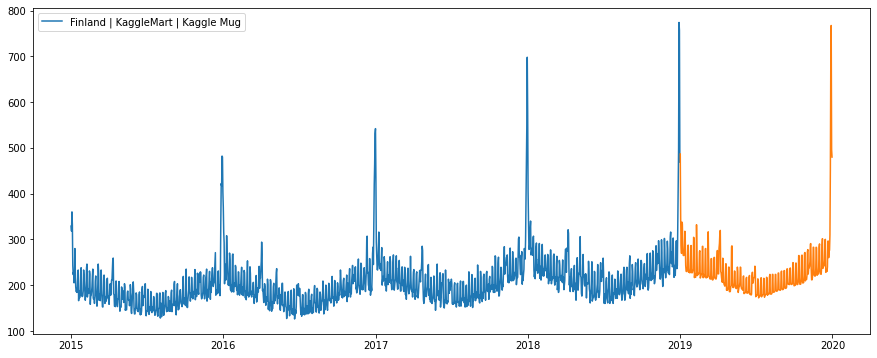

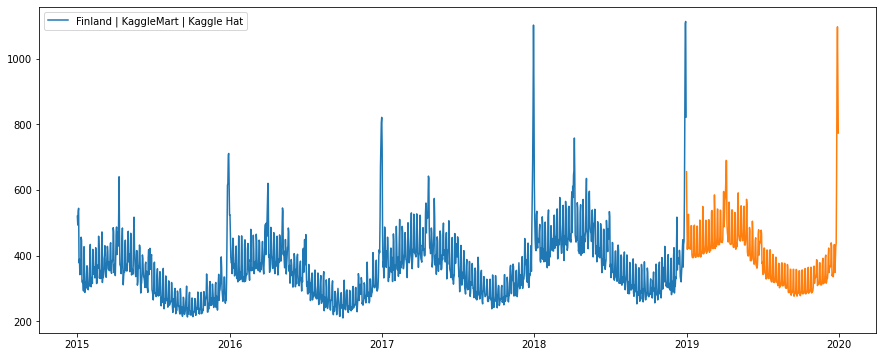

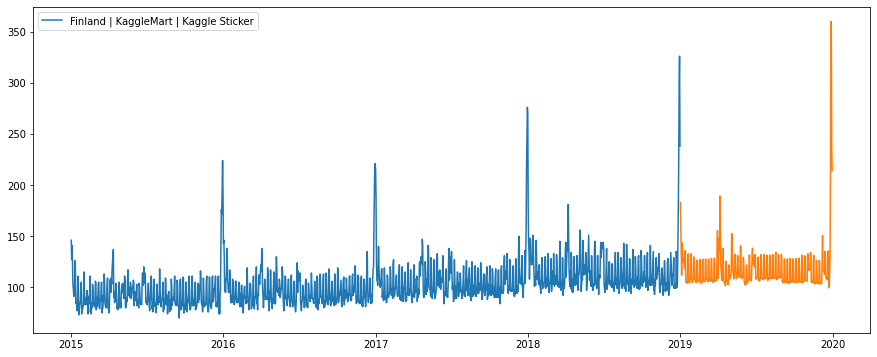

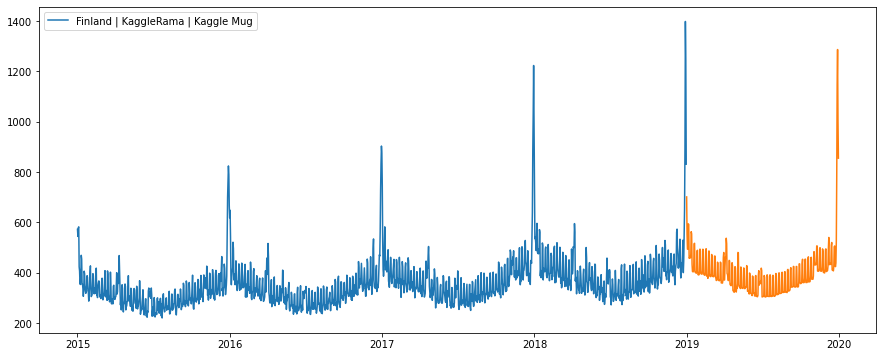

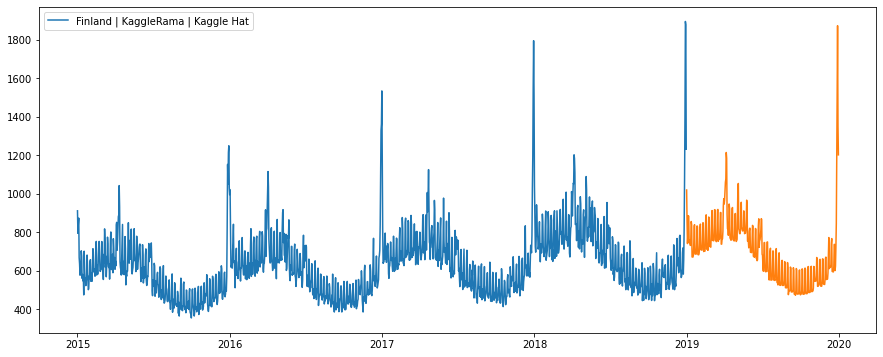

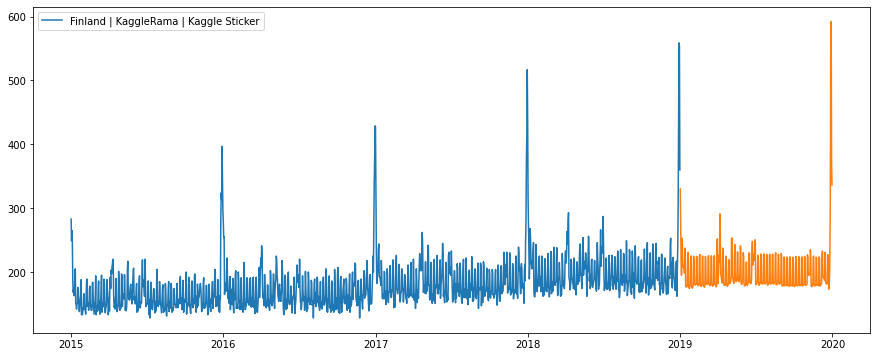

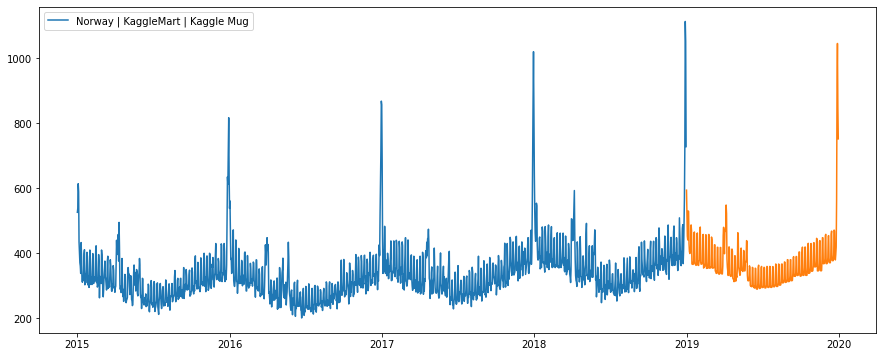

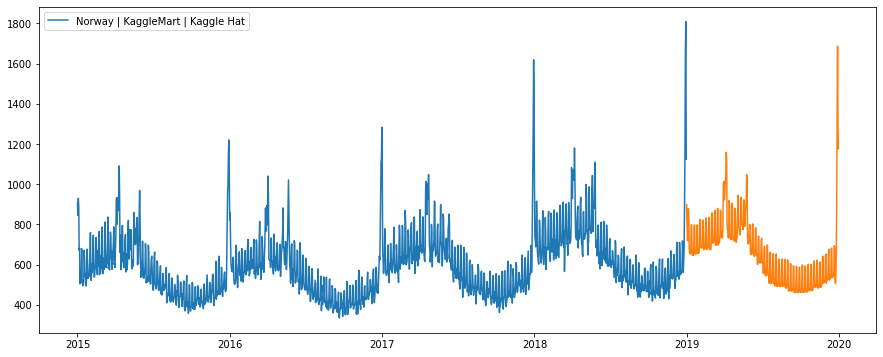

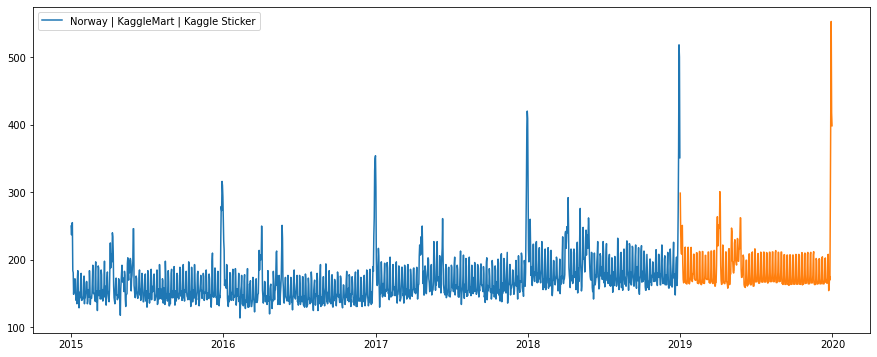

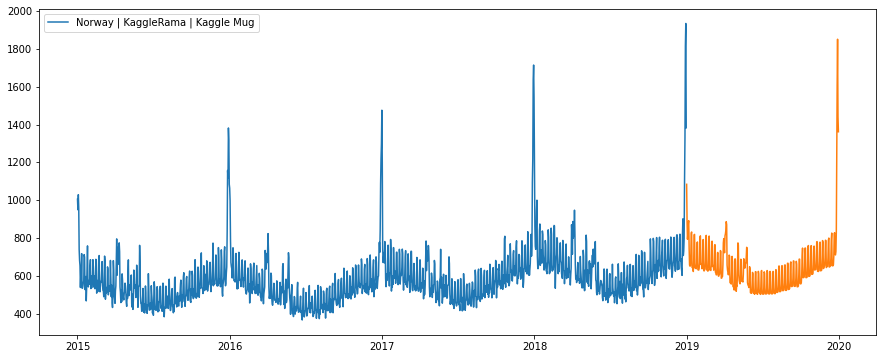

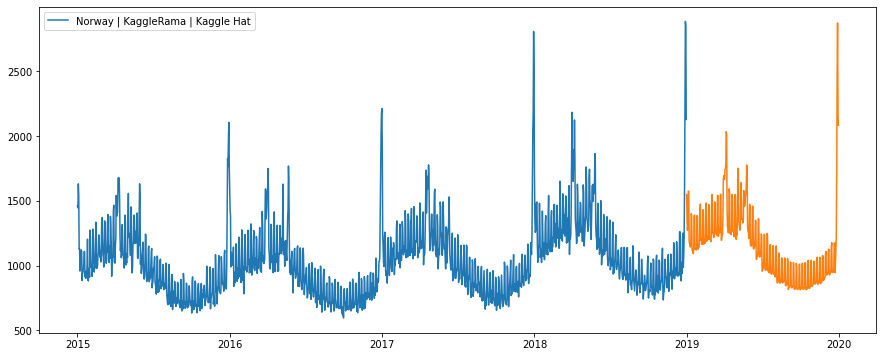

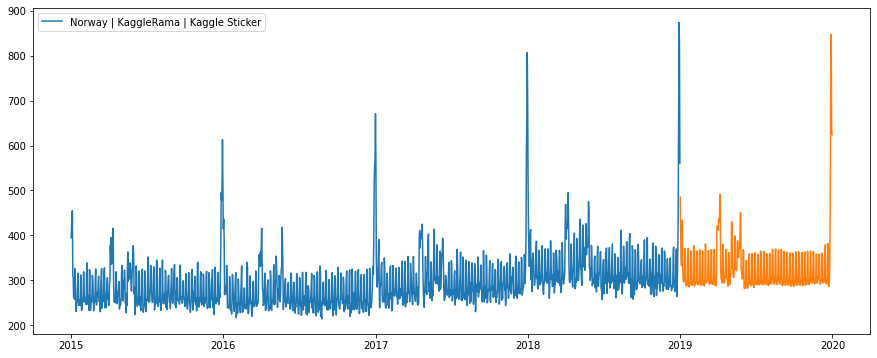

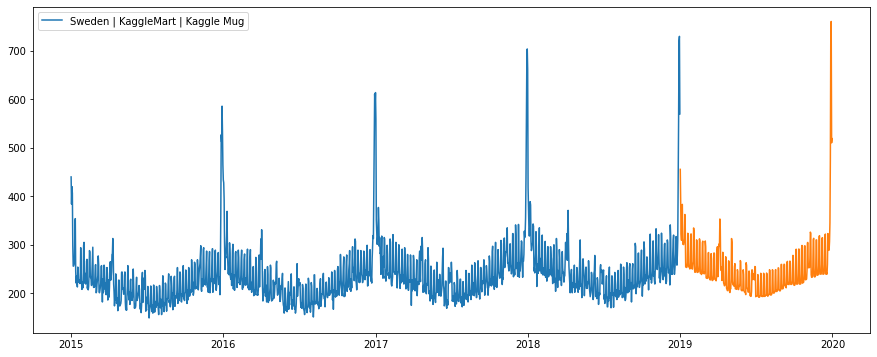

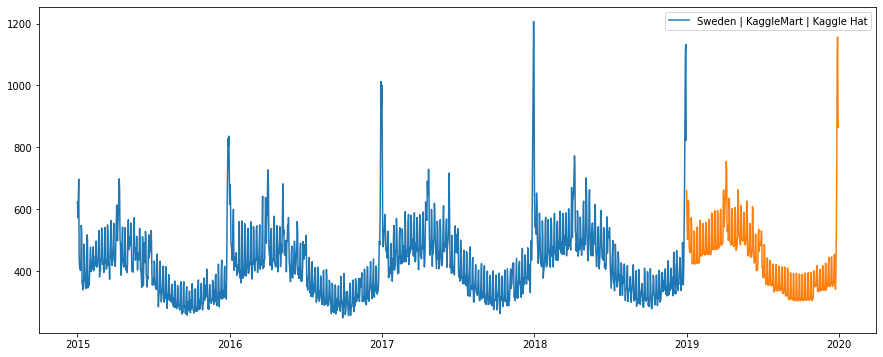

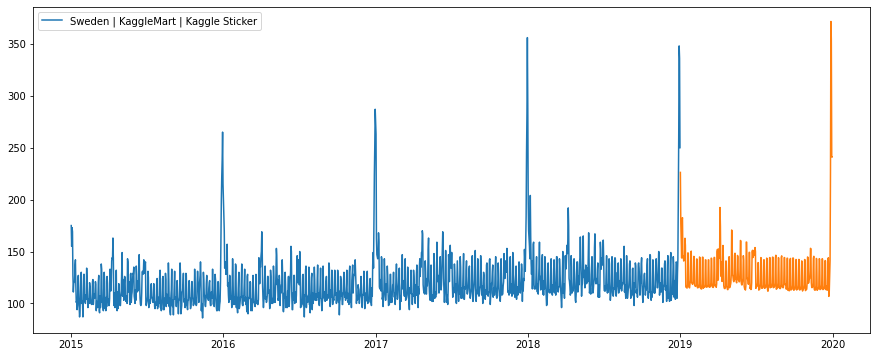

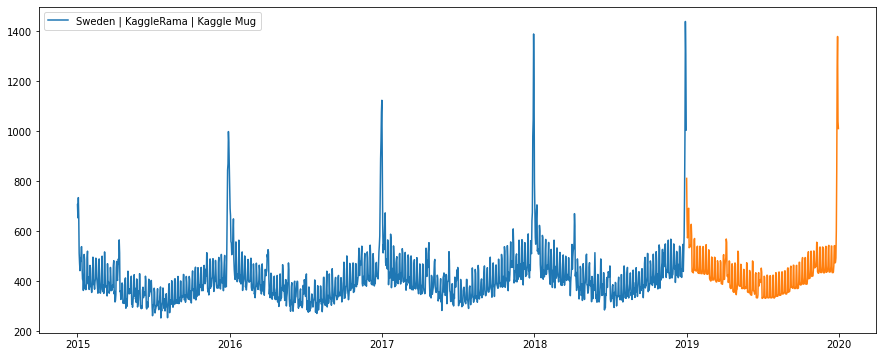

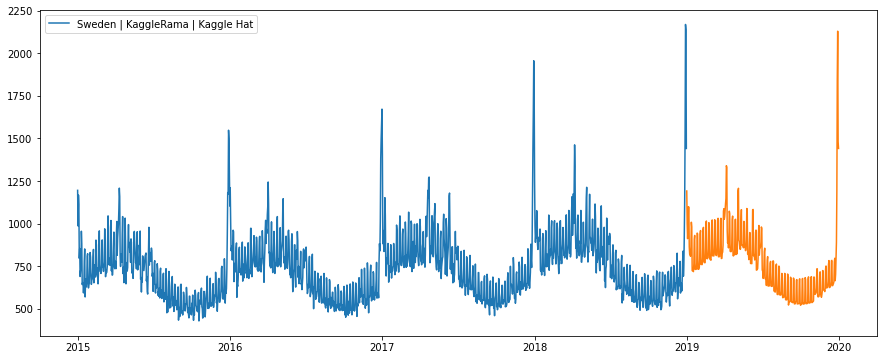

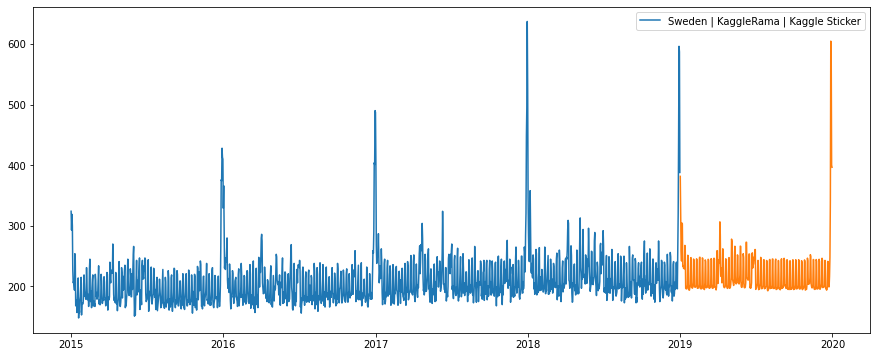

In [11]:
# Forecast and see

# Full data
train_X, train_y = train_.drop('num_sold', axis=1), train_['num_sold']

train_X = lag_data(train_X, 2)
test__ = lag_data(test_, 2)

# Fit and forecast
ts_est.fit(train_X, train_y)
forec = ts_est.predict(test__)
test['num_sold'] = forec

# Vis
train['type'] = 'train'
test['type'] = 'test'

temp = train.append(test)
for c in temp['country'].unique():
    for s in temp['store'].unique():
        for p in temp['product'].unique():
            fig, ax = plt.subplots(figsize=(15,6))
            mask = (temp['country']==c) & (temp['store']==s) & (temp['product']==p)
            sub = temp[mask]
            sub = sub.set_index('date')
            sub_ = sub['num_sold'][sub['type']=='train']
            _ = ax.plot(sub_, label=f'{c} | {s} | {p}')
            sub_ = sub['num_sold'][sub['type']=='test']
            _ = ax.plot(sub_)
            _ = ax.legend()
            plt.show()
            plt.clf()
            plt.close()

In [12]:
# I'll be looking at ways to enhance it
# Feel free to edit yourself.

In [13]:
# ~~~ END ~~~